# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

# Cashflows
## Import Packages

In [2]:
import pandas as pd
from data.data import flow_data_1, flow_data_2
from interesting.cashflow import Cashflow
from interesting.interest import CompoundInterestRate, YearlyCompoundInterestRate

## Build a Cashflow
### From Json

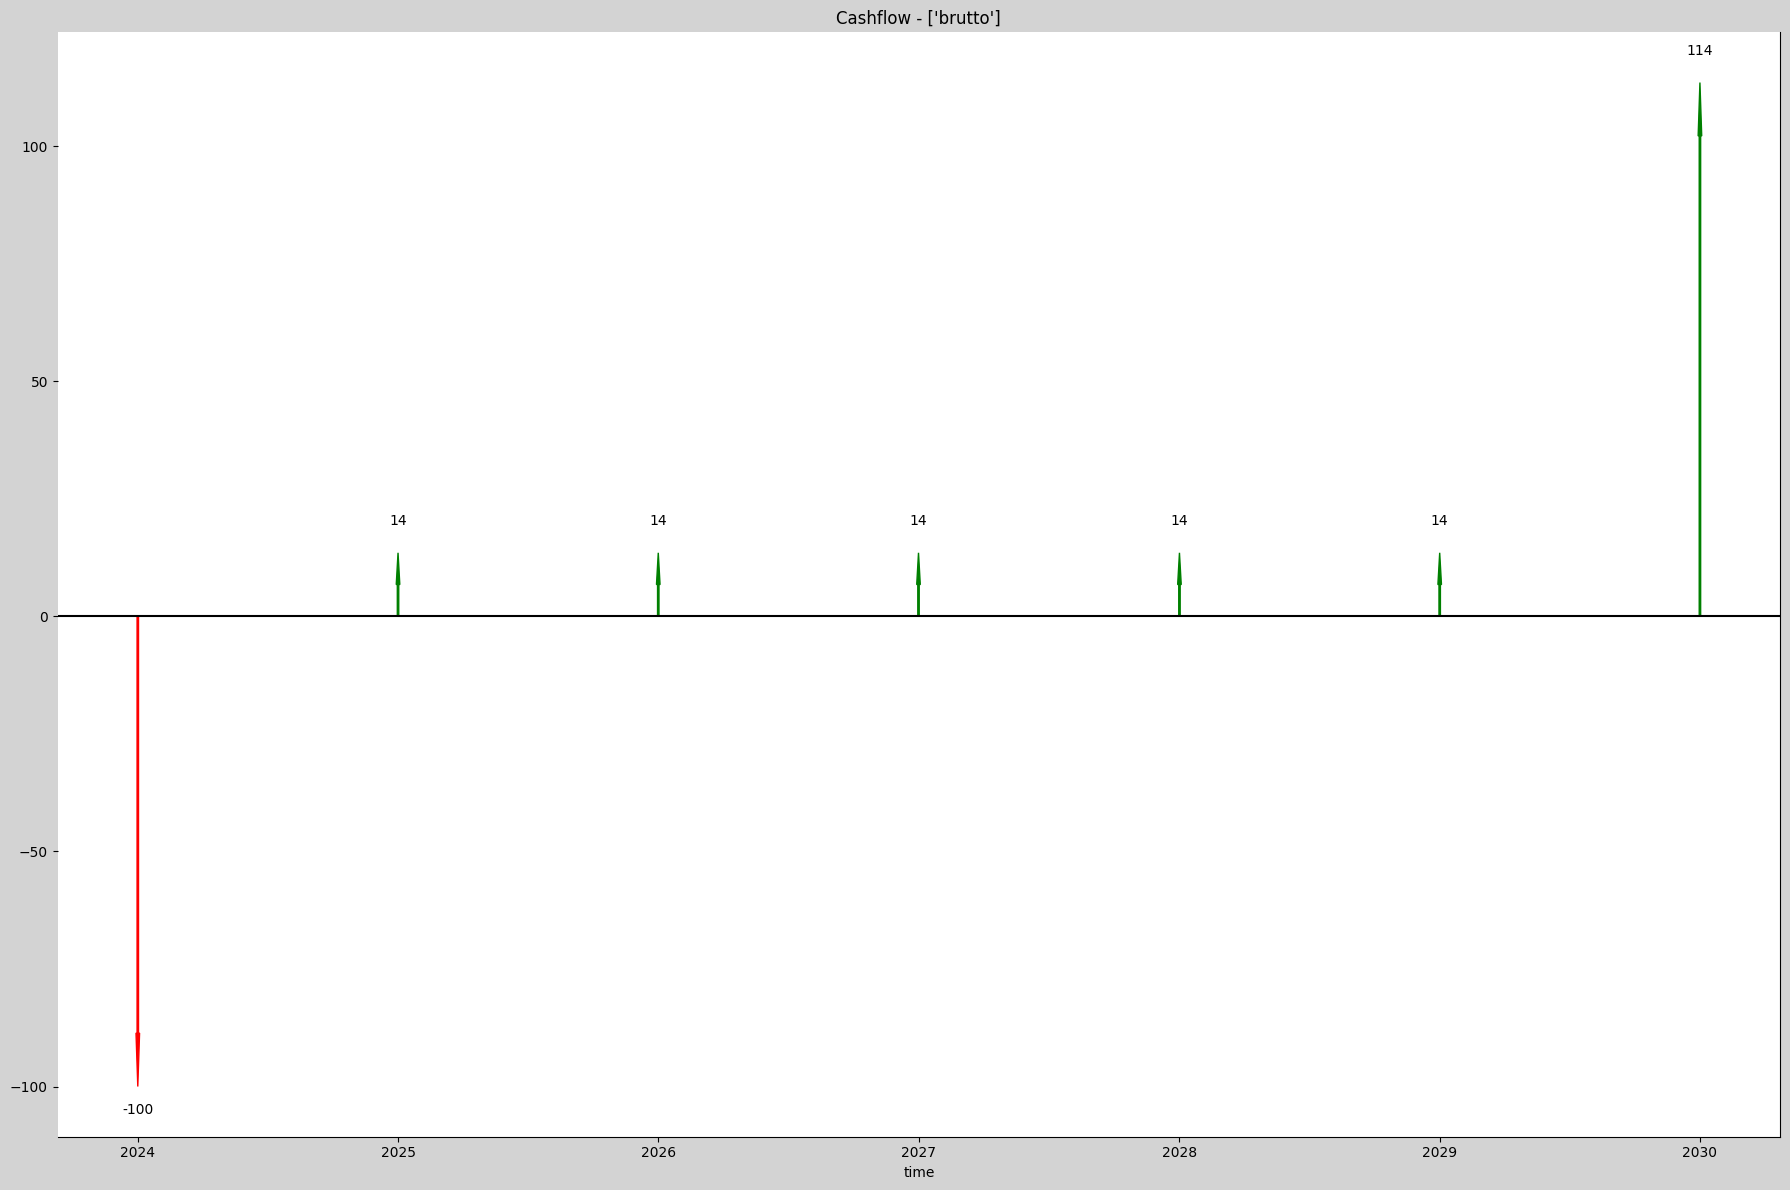

In [3]:
cashflow1 = Cashflow().from_json(flow_data_1)
cashflow1.plot_arrow(targets=["brutto"])

### From Pandas DataFrame

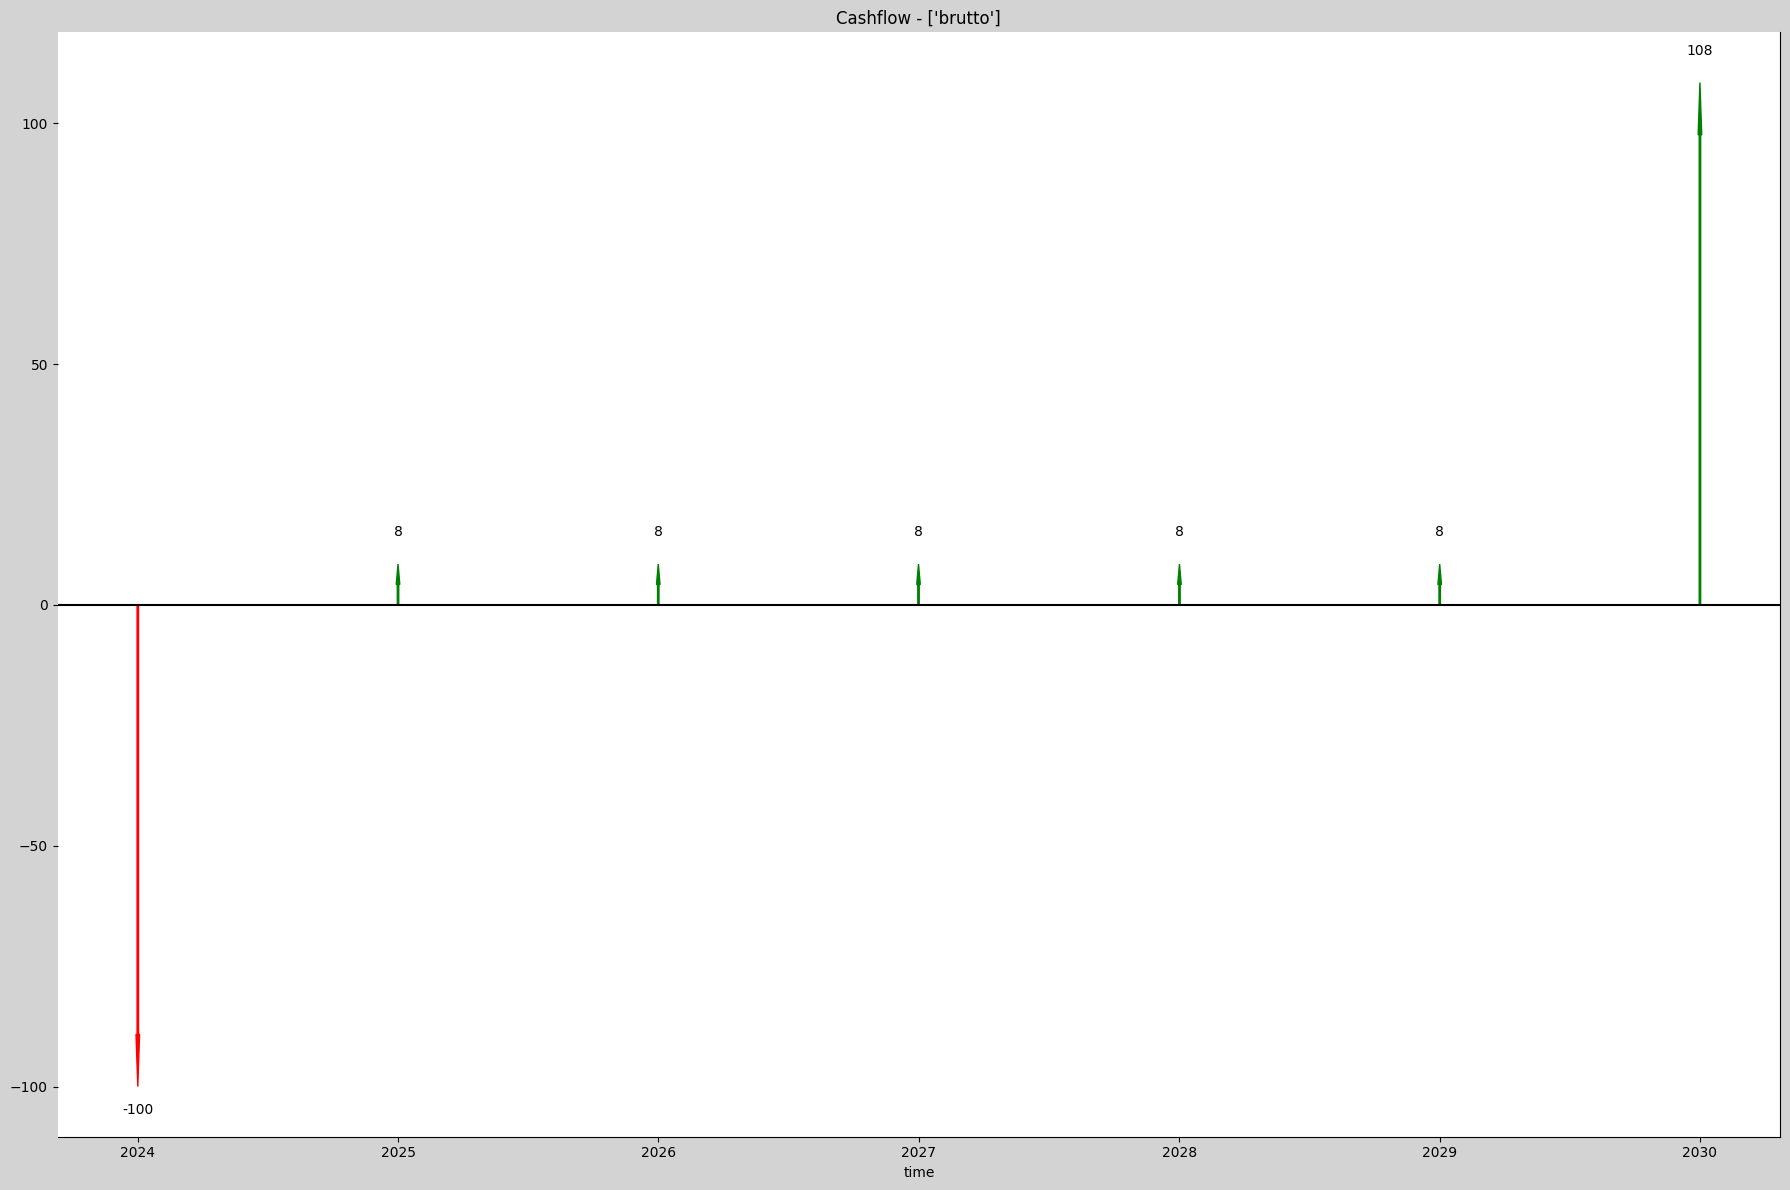

In [4]:
cashflow2 = Cashflow().from_pandas(pd.DataFrame(flow_data_2))
cashflow2.plot_arrow(targets=["brutto"])

# Get information

In [5]:
print(f"dates: {cashflow1.get_dates()}")
print(f"columns: {cashflow1.get_cols()}")
print(f"point: {cashflow1.get_point(("2026-12-31", "brutto"))}")

dates: [Timestamp('2024-12-31 00:00:00'), Timestamp('2025-12-31 00:00:00'), Timestamp('2026-12-31 00:00:00'), Timestamp('2027-12-31 00:00:00'), Timestamp('2028-12-31 00:00:00'), Timestamp('2029-12-31 00:00:00'), Timestamp('2030-12-31 00:00:00')]
columns: ['brutto']
point: 13.5


## Add Cashflows

Cashflow: from 2024-12-31 to 2030-12-31 with 7 rows.


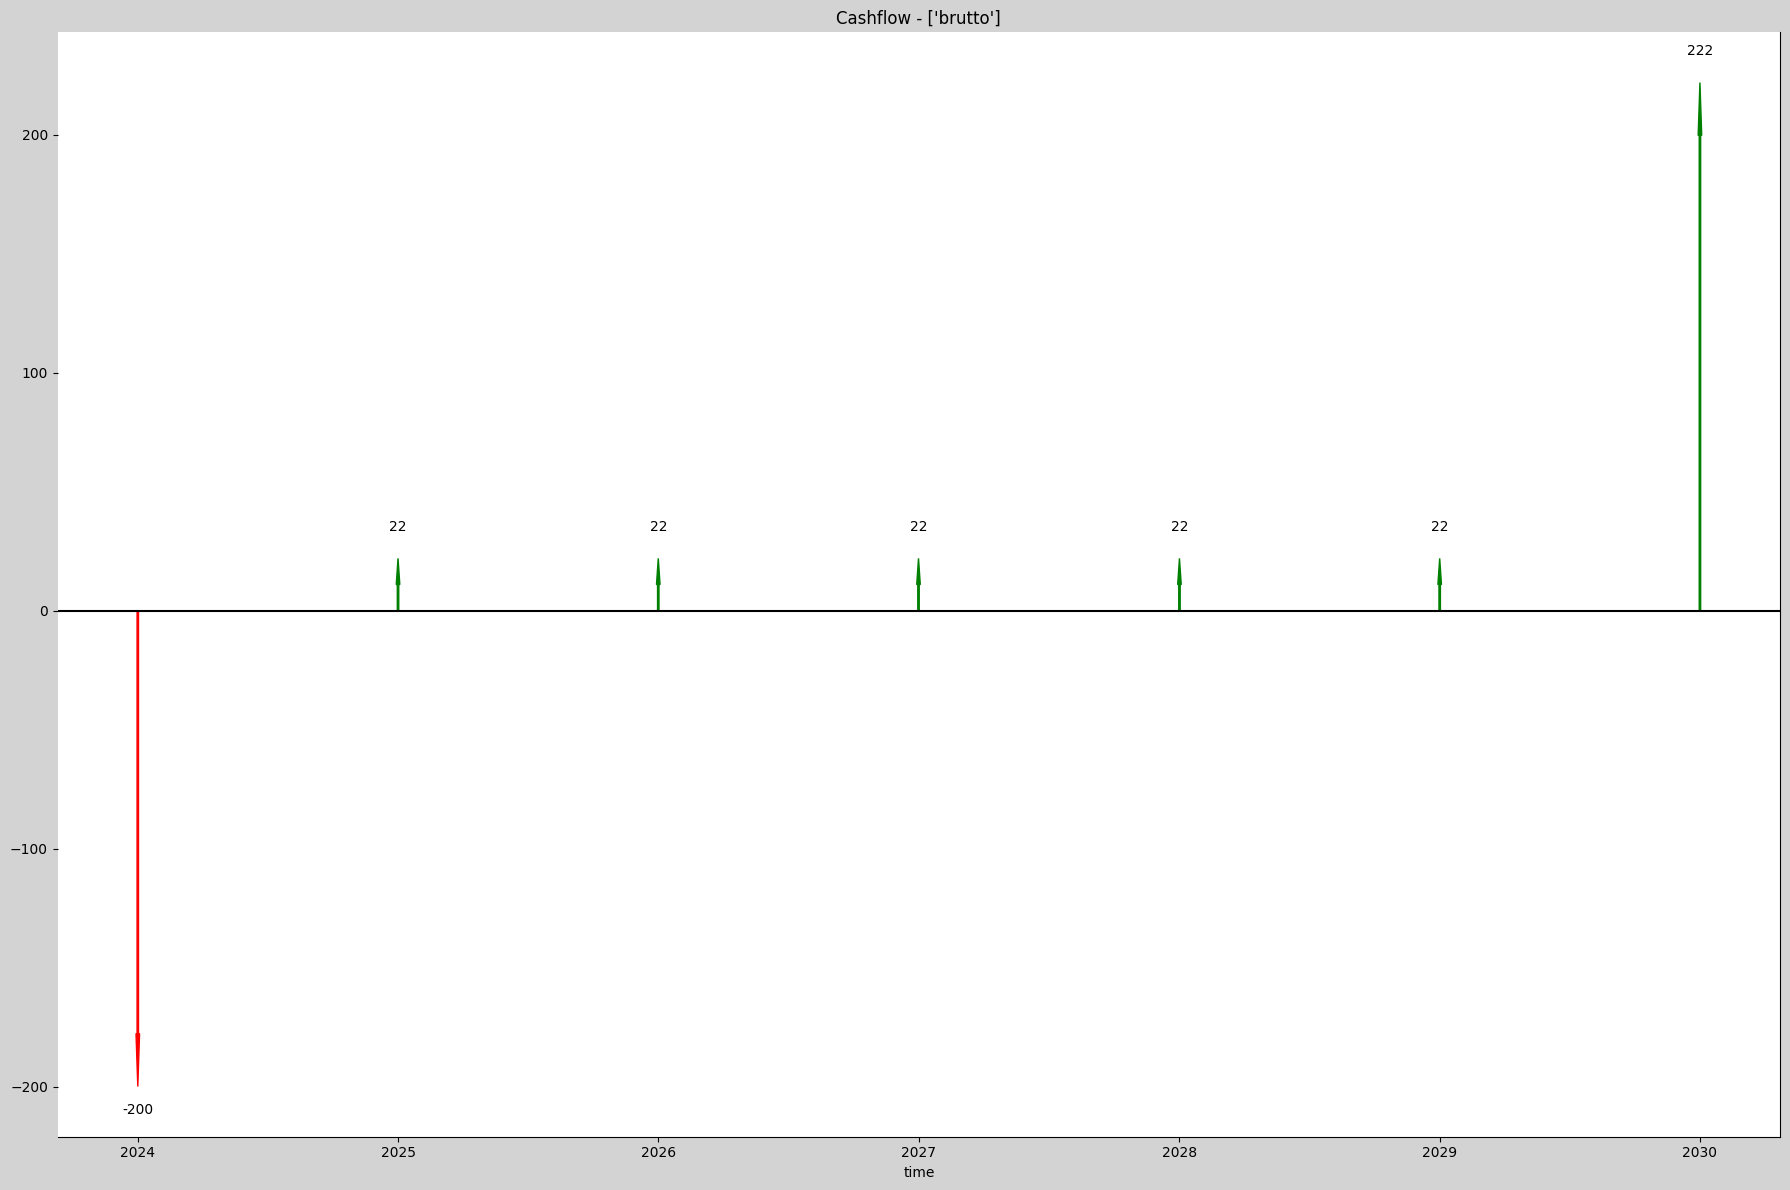

In [6]:
combined_cashflow = cashflow1 + cashflow2

print(combined_cashflow)
combined_cashflow.plot_arrow(targets=["brutto"])

# Interest Rates
## Definition

In [7]:
r = CompoundInterestRate(0.05, freq="Y")
r_yearly = YearlyCompoundInterestRate(0.05)

print(r == r_yearly)

True


## Equivalent rates

In [8]:
# Equivalent rates
r_monthly = CompoundInterestRate(0.015, freq="M")

print((1 + r_monthly.value)**12-1)

r_yearly_equivalent = r_monthly.convert_to_equivalent(new_freq="Y")
print(r_yearly_equivalent)

# Attention!
print(r_yearly_equivalent==r_monthly)

0.19561817146153393
InterestRate(value=0.1956, freq='Y', regime='compound')
True


# Tax

In [9]:
cashflow1.tax()
cashflow1.data

,brutto,principal,interest_paid,delta_days,taxRate,tax,netto
date,,,,,,,
2024-12-31,-100.0,-100,0.0,0,0.20,0.000,-100.000
2025-12-31,13.5,0,13.5,365,0.15,2.025,11.475
2026-12-31,13.5,0,13.5,730,0.15,2.025,11.475
2027-12-31,13.5,0,13.5,1095,0.15,2.025,11.475
2028-12-31,13.5,0,13.5,1461,0.15,2.025,11.475
2029-12-31,13.5,0,13.5,1826,0.15,2.025,11.475
2030-12-31,113.5,100,13.5,2191,0.15,2.025,111.475


# Valuation

In [10]:
cashflow1.discount_from_constant_rate(target="netto", interest=r_yearly)
cashflow1.data

,brutto,principal,interest_paid,delta_days,taxRate,tax,netto,netto_discount_yield,netto_discount_factor,netto_present_value
date,,,,,,,,,,
2024-12-31,-100.0,-100,0.0,0,0.20,0.000,-100.000,0.00,1.000000,-100.000000
2025-12-31,13.5,0,13.5,365,0.15,2.025,11.475,0.05,0.952381,10.928571
2026-12-31,13.5,0,13.5,730,0.15,2.025,11.475,0.05,0.907029,10.408163
2027-12-31,13.5,0,13.5,1095,0.15,2.025,11.475,0.05,0.863838,9.912536
2028-12-31,13.5,0,13.5,1461,0.15,2.025,11.475,0.05,0.822702,9.440511
2029-12-31,13.5,0,13.5,1826,0.15,2.025,11.475,0.05,0.783526,8.990963
2030-12-31,113.5,100,13.5,2191,0.15,2.025,111.475,0.05,0.746215,83.184361


In [11]:
cashflow1.print_npv_and_irr(target="netto")

col: netto
irr: InterestRate(value=0.1148, freq='Y', regime='compound')
npv: Value(value=32.87, price_date='2024-12-31')


# Pension

In [12]:
# How many months will I be in pension? (30 years = 360 months)
n_months = 12*30
# How much money do I want each month?
pension_monthly_salary = 3000
# At which rate is the money pot reinvested?
df = pd.DataFrame()
df["date"] = pd.date_range(start="2025-01-31", periods=n_months+1, freq="ME")
df["brutto"] = [0] + [pension_monthly_salary]*n_months
# market interest rate of 5%/year-> discount rate
r_monthly = YearlyCompoundInterestRate(0.04).convert_to_equivalent(new_freq="M")


# initialize cashflow
pension_cashflow = Cashflow().from_pandas(df)
pension_cashflow = pension_cashflow.discount_from_constant_rate(interest=r_monthly, target="brutto")

# I need 636k to retire with a 3000 salary for 30 years (reinvesting at 4% yearly rate)
pension_cashflow.npv(target="brutto")

Value(value=633,845.12, price_date='2025-01-31')

In [13]:
pension_cashflow.data

,brutto,brutto_discount_yield,brutto_discount_factor,brutto_present_value
date,,,,
2025-01-31,0,0.000000,1.000000,0.000000
2025-02-28,3000,0.003274,0.996737,2990.210828
2025-03-31,3000,0.003274,0.993485,2980.453598
2025-04-30,3000,0.003274,0.990243,2970.728207
2025-05-31,3000,0.003274,0.987012,2961.034551
...,...,...,...,...
2054-09-30,3000,0.003274,0.312376,937.127873
2054-10-31,3000,0.003274,0.311357,934.069971
2054-11-30,3000,0.003274,0.310341,931.022048
